# Simulation Inventory Management

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from scipy import optimize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [26]:
time = 200 # number of length period
d_mu = 100
d_std = 20

# Create an array with 200 demand for 200 periods
d = np.maximum(np.random.normal(d_mu,d_std,time).round(0).astype(int),0)

d

array([119, 137,  76,  78,  97,  92,  75,  61, 119,  88, 106, 109, 103,
        87,  98, 113,  78,  84, 100,  77, 131,  80, 112, 122, 102, 146,
       117, 114,  76,  93,  86, 101, 121, 116, 101,  95, 100,  87, 105,
       110, 108,  61, 123, 148,  95, 127, 114,  88, 104,  79, 105, 104,
       107, 102, 108, 126, 119,  91, 110, 100,  84,  98,  91, 101,  94,
        87,  57,  83,  70, 121, 121,  84, 130,  83, 109,  75,  72, 104,
        81,  71,  87, 133, 105, 114,  93,  72,  72, 133,  92,  43,  90,
       109, 133,  85, 108, 105,  72,  89, 113,  85,  86, 102, 108,  50,
       131,  81, 112,  72,  76, 125, 126, 110, 101, 101,  74, 128,  92,
        81, 116, 113,  88,  93,  96,  84, 101,  94,  39,  91, 102,  89,
        94,  91, 120,  97, 103,  75,  85,  74,  77,  64, 102, 140,  99,
       107, 117, 143,  93,  78, 104, 129,  70,  89,  77,  83, 115, 112,
        86, 105,  95,  74,  78, 100,  91,  99,  66, 100, 103, 122,  78,
        87, 117, 110,  95,  80, 107,  99, 139,  82,  83, 111, 10

In [27]:
# Create the parameters
L, R, alpha = 4, 1, 0.95
z = norm.ppf(alpha)

x_std = np.sqrt(R+L)*d_std

Ss = np.round(x_std*z).astype(int)

Cs = 1/2 * d_mu * R

Is = d_mu * L

S = Ss + 2*Cs + Is

In [28]:
# on hand inventory
hand = np.zeros(time, dtype=int)

# in transit inventory
transit = np.zeros((time,L+1),dtype=int)

Why in transit is 2D array, in order to represent the fact that the orders can stay in-transit for multiple periods (in our example, 4 periods), we will define transit as a 2-dimensional array.

As you can see in Table 5.6, a new order will start at the end of the 2nd dimension (transit[time,-1]) and then make its way through the 2nd dimension as time passes by (one layer per period) until it reaches the last slot (transit[time,0])

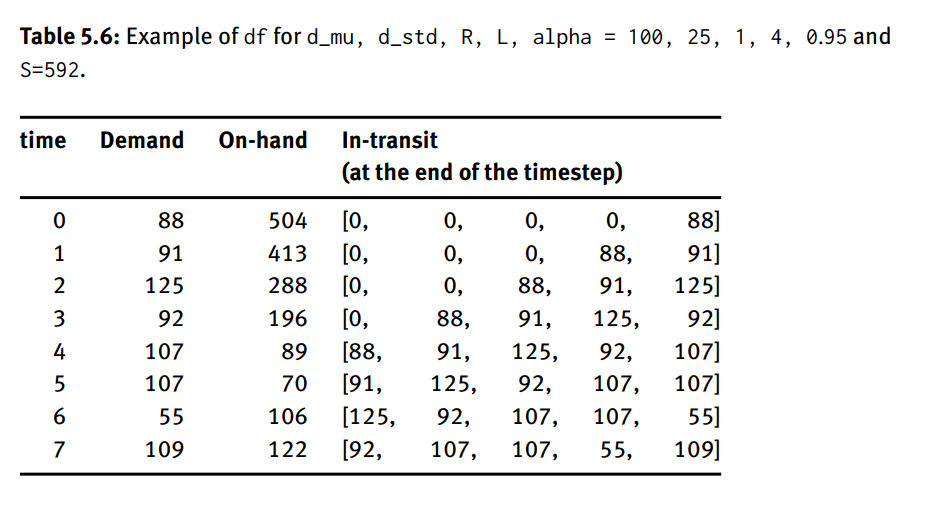

In [29]:
# intialize the hand and in transit
hand[0] = S - d[0]

transit[1,-1] = d[0]




In [30]:
# track the service level
stock_out_period = np.full(time,False,dtype=bool)

stock_out_cycle = [] # shortage each order cycle

## start a simulation

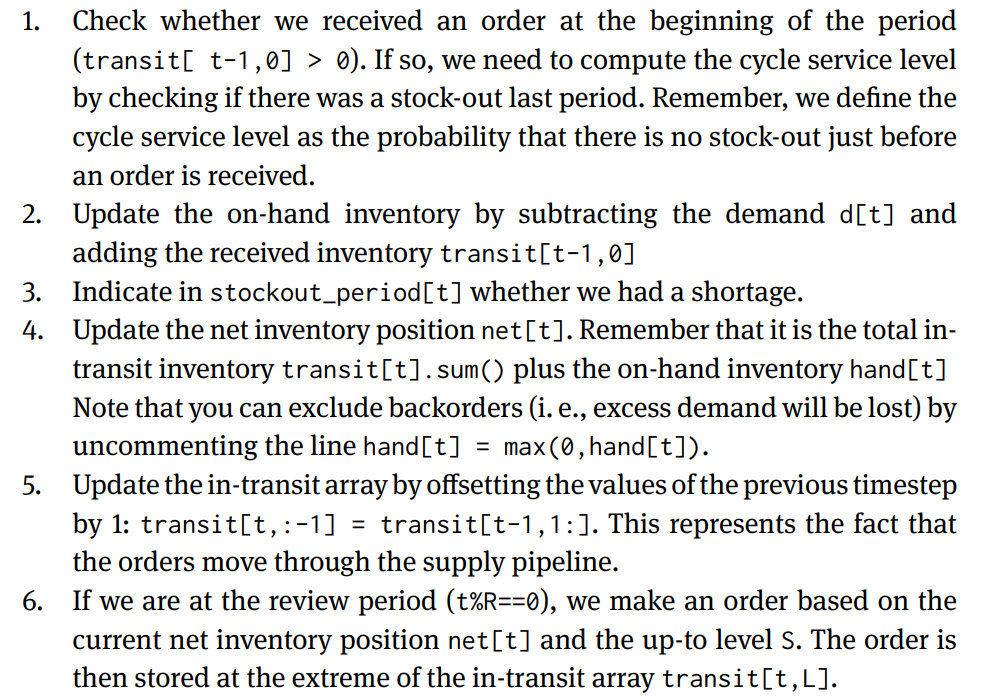

In [31]:
for t in range(1,time):
    if transit[t-1,0] > 0:
        stock_out_cycle.append(stock_out_period[t-1])
    hand[t] = hand[t-1] - d[t] + transit[t-1,0]
    stock_out_period[t] = hand[t] < 0
    # hand[t] = max(0,hand[t]) # uncomment when excess demand result in loss sales than backorders
    transit[t,:-1] = transit[t-1,1:]

    if t%R == 0:
        net = hand[t] + transit[t].sum()
        transit[t,L] = S - net

In [32]:
# store in dataframe
df = pd.DataFrame(data={
    'Demand':d,
    'On hand':hand,
    'In transit':list(transit)
})

df = df.iloc[0:,:] 
# df = df.iloc[R+L:,:] #Remove initialization periods
df

,Demand,On hand,In transit
0,119,455,"[0, 0, 0, 0, 0]"
1,137,318,"[0, 0, 0, 0, 137]"
2,76,242,"[0, 0, 0, 137, 195]"
3,78,164,"[0, 0, 137, 195, 78]"
4,97,67,"[0, 137, 195, 78, 97]"
5,92,-25,"[137, 195, 78, 97, 92]"
6,75,37,"[195, 78, 97, 92, 75]"
7,61,171,"[78, 97, 92, 75, 61]"
8,119,130,"[97, 92, 75, 61, 119]"
9,88,139,"[92, 75, 61, 119, 88]"


<Axes: title={'center': 'Inventory Policy (1,574)'}>

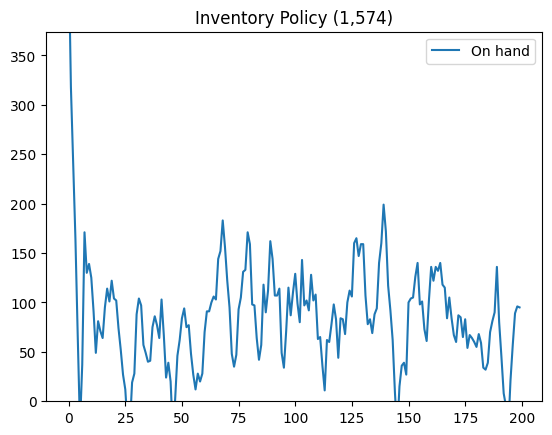

In [33]:
df['On hand'].plot(title='Inventory Policy (%d,%d)' %(R,S), ylim =(0,S-200), legend=True)

In [34]:
print('Alpha:',alpha*100)
SL_alpha = 1-sum(stock_out_cycle)/len(stock_out_cycle)
print('Cycle Service Level:',round(SL_alpha*100,1))
SL_period = 1-sum(stock_out_period)/time
print('Period Service Level:',round(SL_period*100,1))

Alpha: 95.0
Cycle Service Level: 96.4
Period Service Level: 96.5


## Fill Rate and unit short function

In [35]:
d_c, x_std, beta = 100, 50, 0.99

target = d_c*(1-beta)/x_std
target

0.020000000000000018

In [36]:
def normal_loss_standard(x):
    return norm.pdf(x) - x*(1 - norm.cdf(x))

def f(x):
    return abs(normal_loss_standard(x) - target)

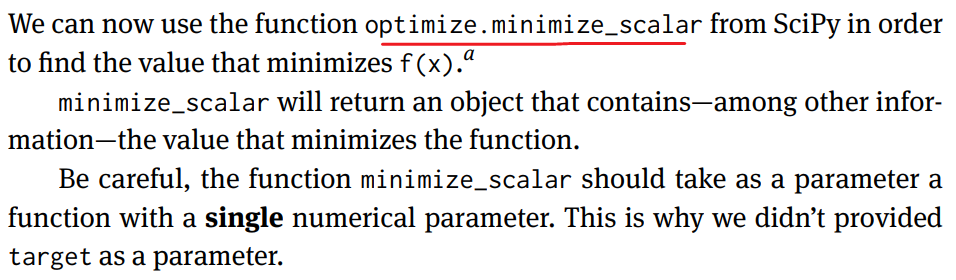

In [37]:
result = optimize.minimize_scalar(f)
print(result)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 3.771691292620005e-10
       x: 1.6630509496216634
     nit: 23
    nfev: 27


In [40]:
z = result.x
z

1.6630509496216634